# Blackjack - prediction

In this notebook, we are interested in *learning* the value-function $v_\pi(s)$ and action-value function $q_\pi(s, a)$ for a given policy $\pi$

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit
from numba.core import types
from numba.typed import Dict

In [6]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(suppress=True)

* **Stick**: Player stops
* **Hit**: Request an additional card

In [7]:
cards = np.array([draw_card(), draw_card()])
cards.sum()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mNameError: name 'deck_probs' is not defined[0m

In [ ]:
@njit
def draw_card():
    return np.random.multinomial(1, deck_probs).argmax()


@njit
def dealer_strategy(value_cards):
    """
    Dealer's fixed strategy
    """
    while value_cards < 17:
        value_cards = value_cards + draw_card()
    return value_cards


@njit
def update_player_card(current_value, new_card):
    """
    Update the player's hand value.
    
    Parameters
    ----------
    current_value: int
        Current value of player's hand
    new_card: int
        Randomly-drawn card
    
    Returns
    -------
    tuple: (int, bool)
        1. New value of player's hand
        2. Whether the there is a usable ace.
    """
    has_usable_ace = False
    if new_card == 1.0 and current_value <= 10:
        new_card = 11
        has_usable_ace = True
        
    new_value = current_value + new_card
    return new_value, has_usable_ace


@njit
def final_reward(value_cards_player, value_cards_dealer):
    if value_cards_player == value_cards_dealer == 21:
        reward = 0 # draw
    elif value_cards_player > 21:
        reward = -1 # lose
    elif value_cards_dealer > 21:
        reward = 1 # win
    elif value_cards_player == value_cards_dealer:
        reward = 0 # draw
    elif value_cards_player > value_cards_dealer:
        reward = 1 # win
    else:
        reward = -1 # lose
    
    return reward


@njit
def init_game():
    value_cards_player = ...
    has_usable_ace = ... # player
    value_cards_dealer = ...
    return value_cards_player, has_usable_ace, value_cards_dealer


@njit
def brokers_strategy():
    ...    


@njit
def step_game(
    value_cards_player, has_usable_ace, value_cards_dealer, policy
):
    continue_play = False # whether the current step terminates the game
    if value_cards_player == 21:
        continue_play = False
    
    return ..., continue_play
    
    


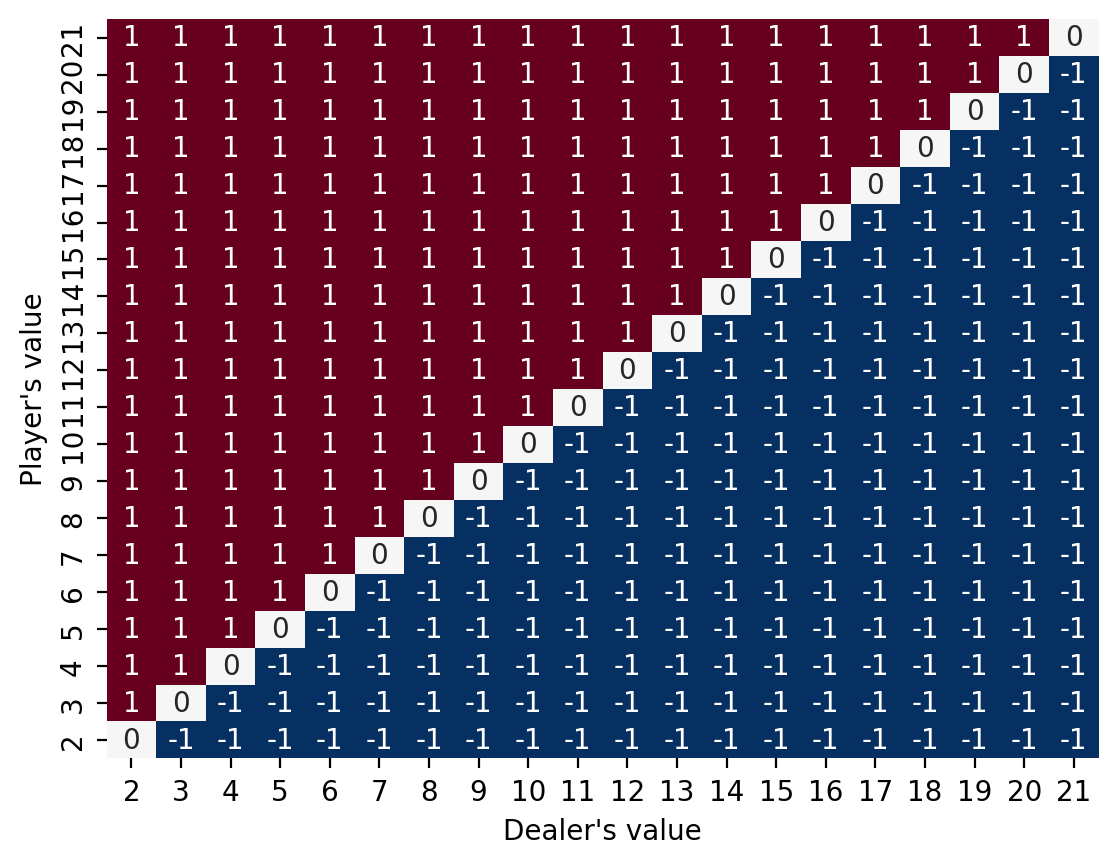

In [35]:
value_cards = np.arange(2, 22)

rewards_grid = np.array([[final_reward(p, d) for d in value_cards] for p in value_cards])
rewards_grid = pd.DataFrame(rewards_grid, index=value_cards, columns=value_cards)
ax = sns.heatmap(rewards_grid, cmap="RdBu_r", annot=True, cbar=False)
ax.invert_yaxis()
plt.ylabel("Player's value")
plt.xlabel("Dealer's value");

In [4]:
@njit
def blackjack(player_value_cards, dealer_cards, policy, has_usable_ace):
    """
    Evaluate a single play of Blackjack.
    
    For some reason, a player can only have a minimum value of 12
    on her initial value cards.
    
    At the start of the game, we are given the initial value of the cards
    of the player, the initial dealer cards and a policy for the player.
    Furtheremore, we are given whether the player has a usable ace.
    
    Actions:
        0: hit
        1: stick
    

    Parameters
    ----------
    player_value_cards: float
        Current value cards for the players
    dealer_cards: jnp.array(2)
        Dealer's initial cards
    policy: jnp.array(G,A)
        2d-array specifying if having value g ∈ G the player
        should take action a ∈ A, i.e., policy[g,a] == 1.0
        if action a should be taken if the value of the cards
        is g.
    has_usable_ace: bool
        Wehether the initial player_value_cards contains a
        usable ace.
    """
    reward = 0
    
    hist_reward = [reward]
    hist_state = [(player_value_cards, has_usable_ace)]
    hist_action = [0]
    
    
    dealer_value_cards = np.sum(dealer_cards)
    
    # Stick if you have 21
    if player_value_cards == 21 and dealer_value_cards != 21:
        reward = 1
        
        hist_reward.append(reward)
        hist_state.append((player_value_cards, has_usable_ace))
        hist_action.append(1)
        
        return reward
    
    # Strickly speaking, the policy should depend on:
    #  1. The current state of the player, i.e., the value of her cards
    #  2. The only card we observe of the dealer
    # In this example, we consider a policy that only depends
    # on the current value of the player's cards.

    # Hit until you reach a 'stick' state or you lose (value of cards over 21)
    while policy[player_value_cards - 12][1] != 1.0:
        new_card = draw_card()
        player_value_cards, new_has_usable_ace = update_player_card(player_value_cards, new_card)
        has_usable_ace = has_usable_ace or new_has_usable_ace # keep usable ace if player already did have one.
        hist_reward.append(0)
        hist_action.append(0)
        hist_state.append((player_value_cards, has_usable_ace))
        
        if player_value_cards > 21:
            break
            
    dealer_value_cards = dealer_strategy(sum(dealer_cards))
    
    if player_value_cards > 21:
        reward = -1
    elif dealer_value_cards > 21:
        reward = 1
    else:
        reward = 1 if player_value_cards > dealer_value_cards else 0
    
    hist_reward.append(reward)
    
    return reward, hist_reward

In [5]:
# We consider the policy that sticks if the 
# player's sum is 20 or 21, and otherwise hits
policy = np.zeros((10, 2))
policy[:-2, 0] = 1
policy[-2:, 1] = 1
policy

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [6]:
# Value 10 corresponds to 10, Jack, Queen, and King.
n_vals = np.ones(10)
n_vals[-1] = 4
deck_probs = n_vals / n_vals.sum()

In [7]:
blackjack(
    player_value_cards=12,
    dealer_cards=np.array([5, 5]),
    policy=policy,
    has_usable_ace=True
)

NameError: name 'blackjack' is not defined

## A Jax implementation

## References
1. https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter05/blackjack.py